# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
def Q1(num_examples=5):
    ### STUDENT START ###

    for i in range(num_examples):
        print(f"\n**** Training example {i} ****")
        print(newsgroups_train.target_names[train_labels[i]])
        print('\n')
        print(train_data[i]) 
        
    ### STUDENT END ###
Q1(5)


**** Training example 0 ****
comp.graphics


Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

**** Training example 1 ****
talk.religion.misc




Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating 

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [4]:
def Q2():
    ### STUDENT START ###
    #Transform the training data into a matrix of word unigram feature vectors.
    print('*** 1. Unigram Feature Vectors ***')
    vectorizer = CountVectorizer()
    vector = vectorizer.fit_transform(train_data)
    
    #What is the size of the vocabulary?
    print('Size of vocabulary: ', len(vectorizer.vocabulary_))
    
    #What is the average number of non-zero features per example?
    print("Average number of non-zero features per example: ", round(np.average([row.nnz for row in vector]),3))
    
    #What is the fraction of the non-zero entries in the matrix?
    sparsity = round((vector.nnz / (vector.shape[0] * vector.shape[1])),3)
    print(f'Fraction of the non-zero entries in the matrix - Sparsity: {sparsity}')
   
    #What are the 0th and last feature strings (in alphabetical order)?
    print("0th feature: ", vectorizer.get_feature_names_out()[0])
    print("Last feature: ", vectorizer.get_feature_names_out()[-1])
    print("\n")
    
    print('*** 2. Vocab Restriction ***')
    #Now transform the training data into a matrix of word unigram feature vectors 
    #restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the size of the vocabulary

    vocabulary = ["atheism", "graphics", "space", "religion"]
    vectorizer = CountVectorizer(vocabulary=vocabulary)
    vectorizer.fit(train_data)
    vector = vectorizer.transform(train_data)

    #print('Size of vocabulary: ', vector.shape[1])
    #What is the average number of non-zero features per example?
    avg_non_zero = round(np.average([row.nnz for row in vector]),3)
    print(f"Average number of non-zero features per example: {avg_non_zero}") 
    print("\n")
    
    print('*** 3. Bigram and Trigram Feature Vectors ***')    
    #Now transform the training data into a matrix of character bigram and trigram feature vectors.
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
    vector = vectorizer.fit_transform(train_data)
    print('Size of vocabulary: ', len(vectorizer.vocabulary_))
    print("\n")
    
    print('*** 4. Prune words that appear in fewer than 10 documents ***')
    vectorizer = CountVectorizer(min_df=10)
    vector = vectorizer.fit_transform(train_data)
    print('Size of vocabulary: ', len(vectorizer.vocabulary_))
    print("\n")
    
    print('*** 5. Unigram dev words missing from train***')
    vectorizer = CountVectorizer()
    vector = vectorizer.fit_transform(train_data)
    vocab_train = vectorizer.vocabulary_

    vectorizer_dev = CountVectorizer()
    devvector = vectorizer_dev.fit_transform(dev_data)
    vocab_dev = vectorizer_dev.vocabulary_
    dev_missing_words = set(vocab_train.keys()) - set(vocab_dev.keys())
    print('Dev vocab missing from the training vocab size: ', len(dev_missing_words))
    
    print('Fraction of words in dev vocab missing from the training vocab: ', round(len(dev_missing_words)/len(vocab_train),3))
    
    ### STUDENT END ###

Q2()

*** 1. Unigram Feature Vectors ***
Size of vocabulary:  26879
Average number of non-zero features per example:  96.706
Fraction of the non-zero entries in the matrix - Sparsity: 0.004
0th feature:  00
Last feature:  zyxel


*** 2. Vocab Restriction ***
Average number of non-zero features per example: 0.268


*** 3. Bigram and Trigram Feature Vectors ***
Size of vocabulary:  35478


*** 4. Prune words that appear in fewer than 10 documents ***
Size of vocabulary:  3064


*** 5. Unigram dev words missing from train***
Dev vocab missing from the training vocab size:  14660
Fraction of words in dev vocab missing from the training vocab:  0.545


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def Q3():
    ### STUDENT START ###
    #Transform the training and development data to matrices of word unigram feature vectors.
    vectorizer = CountVectorizer()
    train_vector = vectorizer.fit_transform(train_data)

    dev_vector = vectorizer.transform(dev_data)
    
    #Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.
    print('***  k-Nearest Neigbors models ***')  
    f1_score_max_knn = 0
    optimal_k = 0

    k_values = [1, 3, 5, 7, 9, 10, 20]
    for k in k_values:
        # Create KNN classifier
        knn = KNeighborsClassifier(n_neighbors = k)
        
        # Train on the mini train set.
        knn.fit(train_vector,train_labels) 
        
        #Evaluate performance on the dev set.
        pred_knn = knn.predict(dev_vector)
        score = metrics.f1_score(dev_labels, pred_knn, average="weighted")
        print(f"k = {k}, f1 score = {score}")
        
        if f1_score_max_knn == 0 or score > f1_score_max_knn:
            f1_score_max_knn = score
            optimal_k = k  
        
    print(f"\noptimized k = {optimal_k}, f1 score = {f1_score_max_knn}")

    #Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score
    print('\n***  Naive Bayes models ***') 
    f1_score_max_nb = 0
    optimal_a = 0
    alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    for a in alphas:
        mnb = MultinomialNB(alpha=a)
        mnb.fit(train_vector, train_labels)

        #Evaluate performance on the dev set.
        pred_mnb = mnb.predict(dev_vector)
        score = metrics.f1_score(dev_labels, pred_mnb, average="weighted")
        print(f"a = {a}, f1 score = {score}")
        
        if f1_score_max_nb == 0 or score > f1_score_max_nb:
            f1_score_max_nb = score
            optimal_a = a
 
    print(f"\noptimized a = {optimal_a}, f1 score = {f1_score_max_nb}")
    
    
    #Produce several Logistic Regression by varying L2 regularization strength (C), 
    #including one with C set approximately to optimize f1 score. 
    #For each model, show the C value, f1 score, and sum of squared weights
    print('\n***  Logistic Regression models ***') 
    f1_score_max_lr = 0
    optimal_c = 0
    c_values  = [0.001, 0.1, 0.50, 0.55, 1.0, 2.0, 5]
    for c_val in c_values:
        lr = LogisticRegression(C=c_val, solver="liblinear", multi_class="auto")
        lr.fit(train_vector, train_labels)
        pred_lr = lr.predict(dev_vector)
        score = metrics.f1_score(dev_labels, pred_lr, average="weighted")

        #sum of squared weights for each topic.
        sum_sq_weights = np.sum(np.square(np.abs(lr.coef_)))
        
        print(f"\nC = {c_val}, f1 score = {score}, sum_sq_weights = {sum_sq_weights}")

        for i in range(lr.coef_.shape[0]):
            sum_sq_weights_topic = np.sum(np.square(np.abs(lr.coef_[i])))
            label = newsgroups_train.target_names[i]
            print(f"{label}: sum sq weights: ", sum_sq_weights_topic)

        if f1_score_max_lr == 0 or score > f1_score_max_lr:
            f1_score_max_lr = score
            optimal_c = c_val
    

    
    lr_opt = LogisticRegression(C=0.55, solver="liblinear", multi_class="auto")
    lr_opt.fit(train_vector, train_labels)
    pred_lr_opt = lr_opt.predict(dev_vector)
    score = metrics.f1_score(dev_labels, pred_lr_opt, average="weighted")
    sum_sq_weights = np.sum(np.square(np.abs(lr_opt.coef_)))
    
    print(f"\noptimized C = {optimal_c}, f1 score = {score}, sum_sq_weights = {sum_sq_weights}")
    ### STUDENT END ###

Q3()

***  k-Nearest Neigbors models ***
k = 1, f1 score = 0.3805030018531525
k = 3, f1 score = 0.4084150225437623
k = 5, f1 score = 0.4287607236218357
k = 7, f1 score = 0.45047910006117586
k = 9, f1 score = 0.4365666176198027
k = 10, f1 score = 0.4278502905941064
k = 20, f1 score = 0.4243419588207676

optimized k = 7, f1 score = 0.45047910006117586

***  Naive Bayes models ***
a = 1e-10, f1 score = 0.747240657284563
a = 0.0001, f1 score = 0.7628348704826354
a = 0.001, f1 score = 0.7702518836155706
a = 0.01, f1 score = 0.7751663218544357
a = 0.1, f1 score = 0.7903052385098862
a = 0.5, f1 score = 0.7862862961995258
a = 1.0, f1 score = 0.7777320236017224
a = 2.0, f1 score = 0.7689966472342658
a = 10.0, f1 score = 0.6674814338256576

optimized a = 0.1, f1 score = 0.7903052385098862

***  Logistic Regression models ***

C = 0.001, f1 score = 0.6193046812006844, sum_sq_weights = 0.7339599204965115
alt.atheism: sum sq weights:  0.1650934516682217
comp.graphics: sum sq weights:  0.20095274690582254

#### ANSWER: 
**Why doesn't k-Nearest Neighbors work well for this problem?**

The K-Nearest Neighbors algorithm assumes similar things exist in close proximity. Because KNN does not have a training phases it uses all of the data. When vectorized the text produces a high dimentional data set. This means the size of the data points start getting father and father apart from each other. K-nearest neighbors requires a point to be close in every single dimension. Sparsity in the data set make it difficult to make predictions accurately.

**Why doesn't Logistic Regression work as well as Naive Bayes does?**

Naive Bayes is a generative model that models the joint distribution of the features and then predicts the posterior probability. Logistic regression is a discriminative model which learns the probability of a sample belonging to a certain class and tries to find the optimal decision boundary that best separates the classes.

Naive Bayes assumes all the features to be conditionally independent. If features are dependent on each other the prediction might be poor. Logistic regression splits feature space linearly even when some of the variables are correlated. This might have a negative impact on prediction.

**What is the relationship between logistic regression's sum of squared weights vs. C value?**

The sum of squares is the sum of the square of variation where variation is the spread between the individual values and the mean. It is used to determine the best fit line. The C value hyperperamer adjusts regulation strength. It allows for a complexity pentalty for more extreme parameters. Extreme parameters in training data can lead to overfitting. A high C value tells the model to give weight to the training data and a lower weight to the complexity pentalty - trust the training data. A low C value gives more weight to complexity penalty at the expense of fitting to training data. In the Logistic models you can see the sum of square values increasing as C increases and f1 score decreasing. This is the spread increasing between the best fit line. The model is overfitting to the training data and impacting predection negatively. 

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [14]:
def Q4():
    ### STUDENT START ###
    #Transform the data to a matrix of word bigram feature vectors. Produce a Logistic Regression model.
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    train_vector = vectorizer.fit_transform(train_data)

    dev_vector = vectorizer.transform(dev_data)  
    
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    
    lr.fit(train_vector, train_labels)
    
    pred_lr = lr.predict(dev_vector)
    score = metrics.f1_score(dev_labels, pred_lr, average="weighted")
    coef = lr.coef_
    
    df = pd.DataFrame(columns = newsgroups_train.target_names)
    all_features = []
    for i in range(coef.shape[0]):
        out_arr = np.argsort(-coef[i])
        top5 = out_arr[0:5]
        all_features = all_features + [vectorizer.get_feature_names_out()[x] for x in top5][::-1]
    df.insert(0, "", all_features, True) 
    

    for index, row in df.iterrows():
        feature = row[0]
        feature_indx = vectorizer.vocabulary_[feature]
        df.loc[index,'alt.atheism'] = round(coef[0][feature_indx],3)
        df.loc[index,'comp.graphics'] = round(coef[1][feature_indx],3)
        df.loc[index,'sci.space'] = round(coef[2][feature_indx],3)
        df.loc[index,'talk.religion.misc'] = round(coef[3][feature_indx],3)
        
    print(df)
    ### STUDENT END ###

Q4()

                        alt.atheism comp.graphics sci.space talk.religion.misc
0             don think       0.592        -0.533    -0.277             -0.303
1      natural morality       0.619        -0.259    -0.265             -0.218
2         cheat hillary       0.665        -0.321    -0.305              0.086
3       promises broken       0.713        -0.318    -0.305             -0.035
4           cheers kent       0.738        -0.922    -0.882              0.772
5              ftp site      -0.339         0.736    -0.257             -0.308
6                24 bit       -0.39         0.776    -0.354             -0.344
7   greatly appreciated      -0.329         0.798     -0.41             -0.305
8         comp graphics      -0.436         1.061    -0.479             -0.367
9        thanks advance      -0.771         1.423    -0.616             -0.696
10          sounds like       -0.04        -0.463     0.513             -0.253
11        space shuttle      -0.239        -0.332   

#### ANSWER:  Do you see any surprising features in this table?
* There are bigram features that are common across topics like cheers kent.
* Top features do not represent category well. For example top features 'are you', 'you are', 'was just' do not reflect the alt.atheism topic. Similaryly 'is there', 'out there' top features are not informative of the comp.graphics topic. 
* Perhaps some ways to improve - remove stop words like “a”, “the”, “is”, “are” and etc by adding stop_words='english'. Use a TfIdf vectorizer to focuses on the most important features. The goal is to remove the noise but not the features that are useful. 

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [22]:
### STUDENT START ###
def text_preprocessor(text):
    text = text.lower()
    text = re.sub("\W",' ',text) # replace non-alphanumeric
    text = re.sub("_",' ',text) # replace non-alphanumeric
    text = re.sub('\n', '', text)   
    return text

def empty_preprocessor(text): 
    return text

def Q5():

    #Produce a Logistic Regression model (with no preprocessing of text)
    print('\n***  Logistic Regression model - No Processing ***') 

    #Pass default preprocesor that removes default lower and strip accents. 
    vectorizer=CountVectorizer(preprocessor=empty_preprocessor)

    vector = vectorizer.fit_transform(train_data)
    print('Size of vocabulary: ', vector.shape[1])
    dev_vector = vectorizer.transform(dev_data)  #transform dev data
    
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    
    lr.fit(vector, train_labels)
    
    pred_lr = lr.predict(dev_vector)
    
    score = round(metrics.f1_score(dev_labels, pred_lr, average="weighted"),2)
    print(f"f1 score = {score}")
    
    
    print('\n***  Logistic Regression model - Processed ***') 
    vectorizer_processed = CountVectorizer(stop_words='english', preprocessor=text_preprocessor)
    
    vector_processed = vectorizer_processed.fit_transform(train_data)
    
    print('Size of processed vocabulary: ', vector_processed.shape[1])

    train_vector_processed = vectorizer_processed.fit_transform(train_data)

    dev_vector_processed = vectorizer_processed.transform(dev_data)  #transform dev data
    
    lr_processed = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    
    lr_processed.fit(train_vector_processed, train_labels)
    
    pred_lr_processed = lr_processed.predict(dev_vector_processed) #evaluate on transformed dev data
    
    score_processed = round(metrics.f1_score(dev_labels, pred_lr_processed, average="weighted"),2)
    
    print(f"f1 score = {score_processed}")
    vocab_reduction = vector.shape[1] - vector_processed.shape[1]
    score_improve = score_processed - score
    print(f"Score improved by = {score_improve}")
    print(f"Vocabulary reduced by = {vocab_reduction}")
    
    ### STUDENT END ###

Q5()


***  Logistic Regression model - No Processing ***
Size of vocabulary:  33291
f1 score = 0.71

***  Logistic Regression model - Processed ***
Size of processed vocabulary:  26146
f1 score = 0.73
Score improved by = 0.020000000000000018
Vocabulary reduced by = 7145


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

L1 regularization -  C = 0.001, f1 score = 0.24492835290439324
L2 regularization - L1 reg strength = 0.001, L2 C = 0.5, f1 score = 0.33356858531863487, vocab size = 3

 
L1 regularization -  C = 0.01, f1 score = 0.4205146637187051
L2 regularization - L1 reg strength = 0.01, L2 C = 0.5, f1 score = 0.4678284761184072, vocab size = 17

 
L1 regularization -  C = 0.1, f1 score = 0.6424582625601405
L2 regularization - L1 reg strength = 0.1, L2 C = 0.5, f1 score = 0.6895689219067682, vocab size = 211

 
L1 regularization -  C = 0.5, f1 score = 0.690919411977676
L2 regularization - L1 reg strength = 0.5, L2 C = 0.5, f1 score = 0.6620186645997764, vocab size = 740

 
L1 regularization -  C = 1.0, f1 score = 0.6917477190557754
L2 regularization - L1 reg strength = 1.0, L2 C = 0.5, f1 score = 0.686856572391577, vocab size = 1129

 
L1 regularization -  C = 2.0, f1 score = 0.6823872559391101
L2 regularization - L1 reg strength = 2.0, L2 C = 0.5, f1 score = 0.6964639450970961, vocab size = 1721

 

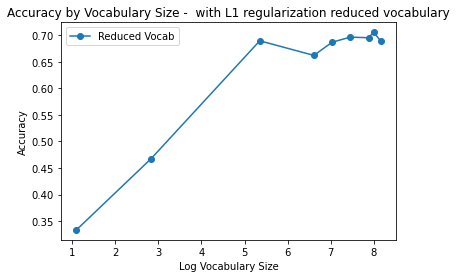

In [17]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    vectorizer = CountVectorizer() 
    vector = vectorizer.fit_transform(train_data)
    
     #transform dev data
    dev_vector = vectorizer.transform(dev_data) 
    
    #print('Size of vocabulary: ', vector.shape[1])
    
    C_values  = [0.001,0.01,0.1,0.50,1.0,2.0,6,8,10]
    f_scores = []
    vocab_size = []
    for c_val in C_values:

        #print('Size of vocabulary: ', vector.shape[1])
        # L1 regularization
        lr1 = LogisticRegression(C=c_val, solver="liblinear",  multi_class="auto", penalty="l1", tol=.015)
        lr1.fit(vector, train_labels)   
    
        pred_lr = lr1.predict(dev_vector)
    
        score = metrics.f1_score(dev_labels, pred_lr, average="weighted")
       
        vocab = vectorizer.vocabulary_

        print(f"L1 regularization -  C = {c_val}, f1 score = {score}")

        nz_indx = []         
        for i in range(lr1.coef_.shape[0]):
            non_zero_idx = np.nonzero(lr1.coef_[i])[0].tolist()
            #print('coef ', len(np.nonzero(lr1.coef_[i])[0].tolist()))
            nz_indx = nz_indx+ np.nonzero(lr1.coef_[i])[0].tolist()  
        nz_indx = np.unique(nz_indx) 

        #Get the vocab to reduce
        vocab_reduce = [vectorizer.get_feature_names_out()[x] for x in nz_indx]
        
        #Use the non zero vocab to reduce
        vectorizer2 = CountVectorizer(vocabulary=vocab_reduce)
        vector2 = vectorizer2.fit_transform(train_data)

        #transform dev data
        dev_vector2 = vectorizer2.transform(dev_data)  
    
        lr2 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", penalty="l2", tol=.015 )
        lr2.fit(vector2, train_labels)   
  
        pred_lr2 = lr2.predict(dev_vector2)
        score = metrics.f1_score(dev_labels, pred_lr2, average="weighted")

        vocab_dev2 = vectorizer2.vocabulary_
        f_scores.append(score)
        vocab_size.append(np.log(len(vocab_dev2)))
        print(f"L2 regularization - L1 reg strength = {c_val}, L2 C = 0.5, f1 score = {score}, vocab size =", len(vocab_dev2))

        print("\n ")
        
    plt.figure() 
    plt.plot(vocab_size, f_scores, marker='o', label = "Reduced Vocab")
    plt.title('Accuracy by Vocabulary Size -  with L1 regularization reduced vocabulary')
    plt.ylabel('Accuracy')
    plt.xlabel('Log Vocabulary Size')
    plt.legend()
    
    plt.show()

    ### STUDENT END ###

Q6()

**ANSWER: How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?**

Reduced vocabularies appears the performance inproves to an extent

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [21]:
def Q7():
    ### STUDENT START ###
    
    #Count Vectorizer
    countvectorizer = CountVectorizer() 
    vector = countvectorizer.fit_transform(train_data) 
    
     #transform dev data
    dev_vector = countvectorizer.transform(dev_data) 
    
    #default is penalty="l2"
    lr_cv =  LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lr_cv.fit(vector, train_labels)   

    pred = lr_cv.predict(dev_vector)
    
    score = metrics.f1_score(dev_labels, pred, average="weighted")
    print(f"\n******** Count Vectorizer ********")
    print(f"Count Vectorizer C = 100, f1 score = {score}, vocab size =", len(countvectorizer.vocabulary_))
    
    #Get estimated probabilities of the predicted classes 
    predict_proba_cv = lr_cv.predict_proba(dev_vector)
    
    #𝑅𝑟𝑎𝑡𝑖𝑜=𝑚𝑎𝑥𝑖𝑚𝑢𝑚 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦 ÷𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡𝑙𝑎𝑏𝑒𝑙
    cv_ratios = [ max(prob)/prob[dev_labels[i]] for i, prob in enumerate(predict_proba_cv)]
    cv_prob_index = np.argsort(cv_ratios)[::-1]
    cv_prob_index_top_3 = cv_prob_index[0:3]
    
    #Show the 3 documents with highest R ratio
    for i, index in enumerate(cv_prob_index_top_3):
        print(f"\n\n**** DOCUMENT {index} ****")
        print("Actual Label: ", newsgroups_train.target_names[dev_labels[index]])
        print("Predicted Label: ", newsgroups_train.target_names[np.argmax(predict_proba_cv[index])])
        print(dev_data[index])

    #Tfidf Vectorizer
    tfidfvectorizer = TfidfVectorizer()
    train_vector_tfIdf = tfidfvectorizer.fit_transform(train_data)
    
     #transform dev tfidfvectorizer
    dev_vector_tfIdf = tfidfvectorizer.transform(dev_data) 
  
    #default is penalty="l2"
    lr_tfIdf =  LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lr_tfIdf.fit(train_vector_tfIdf, train_labels)   

    pred_tfIdf = lr_tfIdf.predict(dev_vector_tfIdf)
    
    score = metrics.f1_score(dev_labels, pred_tfIdf, average="weighted")
    print(f"\n******** Tfidf Vectorizer ********")
    print(f"\nTfidf C = 100, f1 score = {score}, vocab size =", len(tfidfvectorizer.vocabulary_))   
    
    #Get estimated probabilities of the predicted classes 
    predict_proba_tfIdf = lr_tfIdf.predict_proba(dev_vector)

    #𝑅𝑟𝑎𝑡𝑖𝑜=𝑚𝑎𝑥𝑖𝑚𝑢𝑚 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦 ÷𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡𝑙𝑎𝑏𝑒𝑙
    tfIdf_ratios = [max(prob)/prob[dev_labels[i]] for i, prob in enumerate(predict_proba_tfIdf)]
    tfIdf_prob_index = np.argsort(tfIdf_ratios)[::-1]
    tfIdf_prob_index_top_3 = tfIdf_prob_index[0:3]
    
    #Show the 3 documents with highest R ratio
    for i, index in enumerate(tfIdf_prob_index_top_3):
        print(f"\n\n**** DOCUMENT {index} ****")
        print("Actual Label: ", newsgroups_train.target_names[dev_labels[index]])
        print("Predicted Label: ", newsgroups_train.target_names[np.argmax(predict_proba_tfIdf[index])])
        print("\n")
        print(dev_data[index])

    ### STUDENT END ###

Q7()


******** Count Vectorizer ********
Count Vectorizer C = 100, f1 score = 0.6811966141289635, vocab size = 26879


**** DOCUMENT 465 ****
Actual Label:  alt.atheism
Predicted Label:  talk.religion.misc
As requested, here are some addresses of sources of bizarre religious satire
and commentary...  Plus some bijou book reviewettes.

---

Loompanics Unlimited
PO Box 1197
Port Townsend, WA 98368. USA.

Publishers of one of the most infamous mail-order book catalogue in the 
world.  Anarchism, Discordianism, Libertarianism, cryogenics, money-making
(legal and illegal), privacy and security, self-defense, and all kinds of
other stuff that keeps Christians awake at nights.

---

The Church of the SubGenius
PO Box 140306
Dallas, TX 75214. USA.

The original end times church for post-human mutants; a high temple for 
scoffers, mockers and blasphemers.  Be one of the few to board the X-ist 
saucers in 1998 and escape Space God JHVH-1's stark fist of removal.  J.R.
"Bob" Dobbs, God of Sales, is wa


******** Tfidf Vectorizer ********

Tfidf C = 100, f1 score = 0.7597662427853104, vocab size = 26879


**** DOCUMENT 465 ****
Actual Label:  alt.atheism
Predicted Label:  talk.religion.misc


As requested, here are some addresses of sources of bizarre religious satire
and commentary...  Plus some bijou book reviewettes.

---

Loompanics Unlimited
PO Box 1197
Port Townsend, WA 98368. USA.

Publishers of one of the most infamous mail-order book catalogue in the 
world.  Anarchism, Discordianism, Libertarianism, cryogenics, money-making
(legal and illegal), privacy and security, self-defense, and all kinds of
other stuff that keeps Christians awake at nights.

---

The Church of the SubGenius
PO Box 140306
Dallas, TX 75214. USA.

The original end times church for post-human mutants; a high temple for 
scoffers, mockers and blasphemers.  Be one of the few to board the X-ist 
saucers in 1998 and escape Space God JHVH-1's stark fist of removal.  J.R.
"Bob" Dobbs, God of Sales, is waiting to

**How is TfidfVectorizer different than CountVectorizer?**
CountVectorizern counts the number of times a word appears in the document. This results in a bias towards most frequent words and ignoring rare words which could improve prediction. TF-IDF focuses on the frequency of words present in the corpus but also provides the importance of the words by looking at the inverse frequency across all documents. We can then remove the words that are less important for analysis, making the model building less complex by reducing the input dimensions.


**Explain what the R ratio describes.**
R ratio describes how wrong or off the prediciton is to the real value. 

**What kinds of mistakes is the model making?**
The model seems to be considering features independently that have to do with instructional text, product names like Lightwave or individual words like robot and predicitng without consideration of context. Perhaps these rare words are not important for analysis. Perhaps there is a way to adjust the TfidfVectorizer modify the influence of rare words. 

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.